# Proceso  de EDA para estudiar los datos, y preparacion para hacer un modelo de recomendacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import pickle



## Steam Games

In [2]:
steam_games = pd.read_csv('./datasets/steam_games.csv')

In [3]:
steam_games['Year']

0        2018.0
1        2018.0
2        2017.0
3        2017.0
4        2018.0
          ...  
27829    2018.0
27830    2018.0
27831    2018.0
27832    2018.0
27833    2017.0
Name: Year, Length: 27834, dtype: float64

In [4]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27834 entries, 0 to 27833
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   app_name                   27834 non-null  object 
 1   release_date               27774 non-null  object 
 2   price                      27834 non-null  float64
 3   id                         27834 non-null  int64  
 4   developer                  27834 non-null  object 
 5   Accounting                 27834 non-null  int64  
 6   Action                     27834 non-null  int64  
 7   Adventure                  27834 non-null  int64  
 8   Animation &amp; Modeling   27834 non-null  int64  
 9   Audio Production           27834 non-null  int64  
 10  Casual                     27834 non-null  int64  
 11  Design &amp; Illustration  27834 non-null  int64  
 12  Early Access               27834 non-null  int64  
 13  Education                  27834 non-null  int

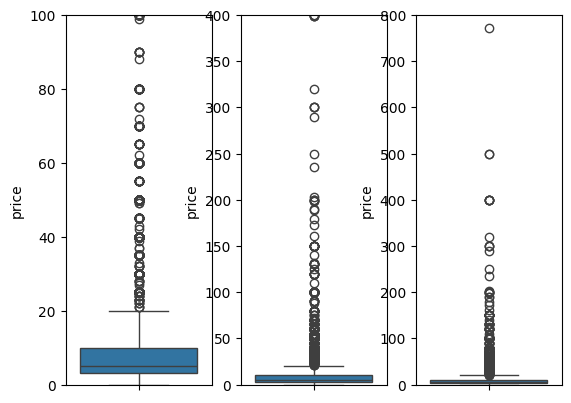

In [5]:
fig,ax = plt.subplots(1,3)
sns.boxplot(data=steam_games,y='price',ax = ax[0])
sns.boxplot(data=steam_games,y='price',ax = ax[1])
sns.boxplot(data=steam_games,y='price',ax = ax[2])
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,400)
ax[2].set_ylim(0,800)
plt.show()

### En el grafico se puede ver que la columna price tiene muchos valores atipicos que superan los 20 y llegan a los 1000, sin embargo en una app de juegos es posible tener tal distribucion, es decir muchos juegos de precio bajo y varios de precio alto por esto no se hara un tratado especial

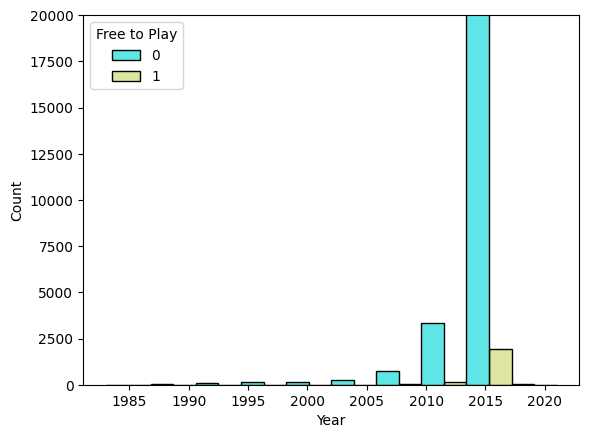

In [6]:
sns.histplot(data=steam_games,x='Year',hue='Free to Play',bins=10,palette='rainbow',multiple='dodge')

plt.ylim(0,20000)
plt.show()

### 2015 es el año con mas juegos y mas juegos Free To Play

## Users Reviews

In [ ]:
user_review = pd.read_csv('./datasets/user_reviews.csv')

In [ ]:
user_review.sample(5)

In [ ]:
sns.histplot(data=user_review,x='sentiment_analysis',bins=10,palette='rainbow',hue='recommend')

plt.show()

### Como se ve del total de sentimiento malos, un alto porcentaje son recomendaciones falsas, y de los buenos el total de recomendaciones true son altas, Para ambas hay un porcentaje existente de recomendaciones que parecen opuesta al sentimiento

## Users Items

In [7]:
with gzip.open('datasets/user_items_proc.csv.gz', 'rb') as f:
    user_items_proc = pd.read_csv(f, encoding='utf-8')

In [8]:
user_items_proc.sample(5)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3865799,icantwait,1409,76561197971666535,http://steamcommunity.com/id/icantwait,63380.0,Sniper Elite V2,96.0,0.0
4997012,76561198088716282,194,76561198088716282,http://steamcommunity.com/profiles/76561198088...,24980.0,Mass Effect 2,154.0,0.0
243782,Black2Darketh,270,76561198082226232,http://steamcommunity.com/id/Black2Darketh,298110.0,Far Cry 4,1121.0,0.0
566653,drdoob,97,76561198174672465,http://steamcommunity.com/id/drdoob,252330.0,Slender: The Arrival,59.0,0.0
2924176,76561198089959203,44,76561198089959203,http://steamcommunity.com/profiles/76561198089...,319630.0,Life Is Strange‚Ñ¢,764.0,0.0


In [9]:
user_items_proc['item_id'].nunique()

10978

In [10]:
user_items_proc.describe()

,items_count,steam_id,item_id,playtime_forever,playtime_2weeks
count,5.153209e+06,5.153209e+06,5.153209e+06,5.153209e+06,5.153209e+06
mean,3.147229e+02,7.656120e+16,1.784481e+05,9.914951e+02,9.104707e+00
std,6.933596e+02,3.916645e+07,1.318598e+05,5.418204e+03,1.403926e+02
min,1.000000e+00,7.656120e+16,1.000000e+01,0.000000e+00,0.000000e+00
25%,7.200000e+01,7.656120e+16,3.446000e+04,0.000000e+00,0.000000e+00
50%,1.380000e+02,7.656120e+16,2.144200e+05,3.400000e+01,0.000000e+00
75%,2.760000e+02,7.656120e+16,2.664300e+05,3.550000e+02,0.000000e+00
max,7.762000e+03,7.656120e+16,5.307200e+05,6.427730e+05,1.996700e+04


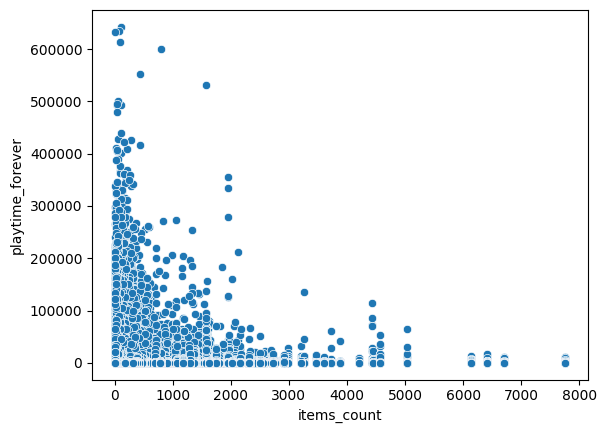

In [11]:
sns.scatterplot(data=user_items_proc,x='items_count',y='playtime_forever')
plt.show()

### Se podria analisar de forma que a menos cantidad de items mas tiempo consume un usuario un juego especifico.

# Modelo de recomendacion

In [ ]:
 
pivot_table = user_items_proc.pivot_table(index='user_id', columns='item_id', fill_value=0)

# Calculamos la matriz de similitud
similarity_matrix = cosine_similarity(pivot_table)

# Convertimos la matriz de similitud a un DataFrame para mejor visualización
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.index, columns=pivot_table.index)

In [13]:

variables = steam_games.drop(columns=['app_name','release_date','price','id','Year','Accounting','developer']).columns
developer_dummies = pd.get_dummies(steam_games['developer'], prefix='developer')
data_encoded = pd.concat([steam_games, developer_dummies], axis=1)
X = data_encoded[list(variables)]
similarities = cosine_similarity(X, X)
knn = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(X)
with open('./model/recommend-item-item.pkl', 'wb') as archivo_pkl:
    pickle.dump(knn, archivo_pkl)

MemoryError: Unable to allocate 5.77 GiB for an array with shape (27834, 27834) and data type float64

In [ ]:
def recomendacion_jueg_fuc(id:int):
    steam_games = pd.read_csv('./datasets/steam_games.csv')
    with open('./model/recommend-item-item.pkl', 'rb') as archivo_pkl:
        knload = pickle.load(archivo_pkl)
    if id not in list(steam_games['id']):
        return "Ese id no pertence a ningun item"
    game_index = steam_games[steam_games['id'] == 761140].index[0]
    distances, indices = knn.kneighbors([X.iloc[game_index]])
    juegos_recomendados = {}

    for i in range(len(indices[0])):
        clave = f"juego {i + 1}" 
        valor = steam_games.iloc[indices[0][i]]['app_name'] 
        juegos_recomendados[clave] = valor 
    return juegos_recomendados